In [1]:
print('Hellp')

Hellp


In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [56]:
TARGET_KEY_BYTE_INDEX = 2
N_SPLITS_CV = 10
MAX_TRACES_CV_EVAL = 1000
CV_EVAL_TRACE_STEP = 10
N_TOP_FEATURES = 100
PLOT_MAX_ATTACK_TRACES = 500 # For final evaluation plots
RANDOM_STATE = 42
N_ESTIMATORS_RF = 100
MAX_DEPTH_RF = 20
MIN_SAMPLES_LEAF_RF = 10


In [4]:
SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
], dtype=np.uint8)

In [5]:
def load_ascad_dataset(file_path, target_key_byte_idx):
    """Loads the ASCAD dataset from an H5 file."""
    with h5py.File(file_path, "r") as f:
        profiling_traces = f["Profiling_traces/traces"][:]
        profiling_labels = f["Profiling_traces/labels"][:]
        attack_traces = f["Attack_traces/traces"][:]
        # y_test (attack_labels) is not used directly in key rank for an unknown key scenario,
        # but good to load if you were to compute model accuracy on attack S-box outputs.
        _ = f["Attack_traces/labels"][:] 
        attack_plaintexts = f["Attack_traces/metadata"]["plaintext"][:].astype(np.uint8)
        # The key in ASCAD metadata is stored as an array of bytes for the full key.
        # We extract the byte at the target_key_byte_idx.
        true_key_byte = int(f["Attack_traces/metadata"]["key"][0][target_key_byte_idx])
    return profiling_traces, profiling_labels, attack_traces, attack_plaintexts, true_key_byte


In [ ]:
ASCAD_FILE_PATH = "ASCAD.h5" 
try:
    X_profiling_raw, y_profiling, X_attack_raw, attack_plaintexts, true_key_byte = load_ascad_dataset(
        ASCAD_FILE_PATH, TARGET_KEY_BYTE_INDEX
    )
    print(f"Successfully loaded ASCAD dataset from: {ASCAD_FILE_PATH}")
except IOError:
    print(f"ERROR: ASCAD.h5 not found at {ASCAD_FILE_PATH}.")
    print("Please download the ASCAD.h5 dataset and place it in the correct path or update ASCAD_FILE_PATH.")
    # Create dummy data to allow the rest of the notebook to run for structure checking,
    # but actual results will be meaningless.
    print("Using dummy data for notebook structure demonstration.")
    X_profiling_raw = np.random.rand(50000, 700).astype(np.float32)
    y_profiling = np.random.randint(0, 256, 50000, dtype=np.uint8)
    X_attack_raw = np.random.rand(10000, 700).astype(np.float32)
    attack_plaintexts = np.random.randint(0, 256, (10000, 16), dtype=np.uint8)
    true_key_byte = 42 # Arbitrary true key for dummy data
print(f"Profiling traces shape: {X_profiling_raw.shape}")
print(f"Profiling labels shape: {y_profiling.shape}")
print(f"Attack traces shape: {X_attack_raw.shape}")
print(f"Attack plaintexts shape: {attack_plaintexts.shape}")
print(f"True key byte for attack set: {true_key_byte} (0x{true_key_byte:02X})")


In [7]:
# Normalize/Scale traces
# Using StandardScaler, fit only on profiling data
scaler = StandardScaler()
X_profiling_scaled = scaler.fit_transform(X_profiling_raw)
X_attack_scaled = scaler.transform(X_attack_raw)

print("Data scaled using profiling set statistics.")
print(f"Mean of scaled profiling data (first 5 features): {X_profiling_scaled[:,:5].mean(axis=0)}")
print(f"Std dev of scaled profiling data (first 5 features): {X_profiling_scaled[:,:5].std(axis=0)}")


Data scaled using profiling set statistics.
Mean of scaled profiling data (first 5 features): [-1.87023730e-16  1.28503541e-15  1.23502425e-15 -2.52148302e-17
 -2.79962165e-16]
Std dev of scaled profiling data (first 5 features): [1. 1. 1. 1. 1.]


In [8]:
# Slightly modified and detailed than the CNN version
def compute_key_rank(model, attack_traces, plaintexts, true_key_value,
                     n_traces_for_rank, sbox_array, target_plaintext_byte_idx,
                     epsilon=1e-12, precomputed_probs=None):
    
    num_available_traces_total = plaintexts.shape[0]
    # Ensure we don't try to use more traces than available or more than specified for this rank computation
    n_traces_to_use = min(n_traces_for_rank, num_available_traces_total)

    if n_traces_to_use == 0:
        return 255, np.zeros(256) # Max rank (worst) if no traces are used

    # Get probabilities from the model for the selected traces
    if precomputed_probs is None:
        probabilities = model.predict_proba(attack_traces[:n_traces_to_use])
    else:
        if precomputed_probs.shape[0] < n_traces_to_use:
            raise ValueError(f"Precomputed_probs has {precomputed_probs.shape[0]} traces, but {n_traces_to_use} are needed.")
        probabilities = precomputed_probs[:n_traces_to_use]
    
    # Ensure probabilities are valid and normalized (sum to 1 per trace)
    probabilities = np.maximum(probabilities, epsilon) # Prevent log(0)
    row_sums = probabilities.sum(axis=1, keepdims=True)
    # Avoid division by zero if a row_sum is zero (e.g. all probabilities were < epsilon and got floored)
    probabilities = np.divide(probabilities, row_sums, out=np.zeros_like(probabilities), where=row_sums!=0)


    key_log_likelihoods = np.zeros(256) # Log-likelihood scores for each key hypothesis

    for key_guess in range(256):
        # Calculate S-box(plaintext_byte ^ key_guess) for all traces uand ensure plaintexts array is also sliced to n_traces_to_use
        intermediate_values = sbox_array[plaintexts[:n_traces_to_use, target_plaintext_byte_idx] ^ key_guess]

        # P(Trace_i | Sbox_out_k_guess) = probabilities[i, Sbox_out_k_guess_for_trace_i]
        trace_specific_probabilities = probabilities[np.arange(n_traces_to_use), intermediate_values]
        
        # Sum the log-probabilities for the current key_guess
        key_log_likelihoods[key_guess] = np.sum(np.log(trace_specific_probabilities))

    # Rank keys by their log-likelihood 
    ranked_key_indices = np.argsort(key_log_likelihoods)[::-1] # Descending order

    true_key_rank = np.where(ranked_key_indices == true_key_value)[0][0]

    return true_key_rank, key_log_likelihoods


In [ ]:
# Just checking CV
kf = KFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)

cv_traces_needed_for_rank0 = []
cv_profiling_train_accuracies = []
cv_profiling_val_accuracies = []

fold_counter = 1
for train_idx, val_idx in kf.split(X_profiling_scaled):
    print(f"\n--- Fold {fold_counter}/{N_SPLITS_CV} ---")

    X_prof_train_fold, X_prof_val_fold = X_profiling_scaled[train_idx], X_profiling_scaled[val_idx]
    y_prof_train_fold, y_prof_val_fold = y_profiling[train_idx], y_profiling[val_idx]

    print(f"Profiling Training set size for fold: {X_prof_train_fold.shape[0]}")
    print(f"Profiling Validation set size for fold: {X_prof_val_fold.shape[0]}")

    print("Defining and Training Random Forest model for this fold...")
    rf_model_fold = RandomForestClassifier(
        n_estimators=N_ESTIMATORS_RF,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        max_depth=MAX_DEPTH_RF,
        min_samples_leaf=MIN_SAMPLES_LEAF_RF,
        verbose=0
    )
    rf_model_fold.fit(X_prof_train_fold, y_prof_train_fold)
    print("Model training finished for this fold.")

    # Evaluate S-box prediction accuracy on profiling data for this fold
    y_pred_train_fold = rf_model_fold.predict(X_prof_train_fold)
    y_pred_val_fold = rf_model_fold.predict(X_prof_val_fold)
    train_acc_fold = accuracy_score(y_prof_train_fold, y_pred_train_fold)
    val_acc_fold = accuracy_score(y_prof_val_fold, y_pred_val_fold)
    cv_profiling_train_accuracies.append(train_acc_fold)
    cv_profiling_val_accuracies.append(val_acc_fold)
    print(f"S-box Accuracy (Fold {fold_counter}): Train={train_acc_fold*100:.2f}%, Validation={val_acc_fold*100:.2f}%")

    print(f"Evaluating key rank progress on ATTACK set using Fold {fold_counter}'s model (up to {MAX_TRACES_CV_EVAL} traces)...")
    traces_to_rank_0_fold = float('inf') # Infinity if Rank 0 is not reached
    
    # Determine the actual maximum number of attack traces to use for this fold's evaluation
    actual_max_traces_for_fold_eval = min(MAX_TRACES_CV_EVAL, X_attack_scaled.shape[0])
    
    attack_probs_current_fold_model = None
    if actual_max_traces_for_fold_eval > 0:
        print(f"Precomputing probabilities for {actual_max_traces_for_fold_eval} attack traces with fold model...")
        attack_probs_current_fold_model = rf_model_fold.predict_proba(X_attack_scaled[:actual_max_traces_for_fold_eval])
        print("Done precomputing for fold model.")

        for n_tr in range(CV_EVAL_TRACE_STEP, actual_max_traces_for_fold_eval + 1, CV_EVAL_TRACE_STEP):
            if n_tr == 0: continue
            rank, _ = compute_key_rank(
                model=rf_model_fold,
                attack_traces=X_attack_scaled, # Pass full, function slices based on n_tr with precomputed_probs
                plaintexts=attack_plaintexts,
                true_key_value=true_key_byte,
                n_traces_for_rank=n_tr,
                sbox_array=SBOX,
                target_plaintext_byte_idx=TARGET_KEY_BYTE_INDEX,
                precomputed_probs=attack_probs_current_fold_model 
            )
            if rank == 0:
                traces_to_rank_0_fold = n_tr
                print(f"** Success! Rank 0 reached after {n_tr} attack traces (Fold {fold_counter}). **")
                break
    
    if traces_to_rank_0_fold == float('inf'):
        print(f"-- Failure: Rank 0 not reached within {actual_max_traces_for_fold_eval} attack traces (Fold {fold_counter}). --")
    
    cv_traces_needed_for_rank0.append(traces_to_rank_0_fold)
    fold_counter += 1

print(f" {MAX_TRACES_CV_EVAL}")
print(f"Traces needed to reach Rank 0 (inf = not reached):\n- {cv_traces_needed_for_rank0}")

successful_folds_cv = [t for t in cv_traces_needed_for_rank0 if t != float('inf')]
num_successful_folds_cv = len(successful_folds_cv)
success_rate_cv = (num_successful_folds_cv / N_SPLITS_CV) * 100

print(f"\nSuccess Rate (Rank 0 reached within {MAX_TRACES_CV_EVAL} traces): {success_rate_cv:.1f}% ({num_successful_folds_cv}/{N_SPLITS_CV} folds)")

if num_successful_folds_cv > 0:
    print(f"\nStatistics for SUCCESSFUL folds:")
    print(f"- Average Traces Needed: {np.mean(successful_folds_cv):.2f}")
    print(f"- Standard Deviation: {np.std(successful_folds_cv):.2f}")
    print(f"- Minimum Traces Needed: {np.min(successful_folds_cv)}")
    print(f"- Maximum Traces Needed (among successful): {np.max(successful_folds_cv)}")
else:
    print(f"\nNo folds reached Rank 0 within the {MAX_TRACES_CV_EVAL} trace limit during CV.")

print("\nS-box Prediction Accuracy Summary (on Profiling data splits):")
print(f"- Average Training Accuracy: {np.mean(cv_profiling_train_accuracies)*100:.2f}%")
print(f"- Average Validation Accuracy: {np.mean(cv_profiling_val_accuracies)*100:.2f}%")


In [10]:
# ## 6. Random Forest: Final Model and Evaluation
# Train on all profiling data and evaluate on the attack set.

# %%
print("\n--- Training Final Random Forest Model on ALL Profiling Data ---")
rf_final_model = RandomForestClassifier(
    n_estimators=N_ESTIMATORS_RF,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    max_depth=MAX_DEPTH_RF,
    min_samples_leaf=MIN_SAMPLES_LEAF_RF,
    verbose=1 # Show some training progress
)
rf_final_model.fit(X_profiling_scaled, y_profiling)
print("Final RF model training finished.")

# Helper function to compute key rank and plot results
def plot_key_rank_vs_traces(trace_counts, ranks, model_name, color='blue', linestyle='-'):
    plt.plot(trace_counts[:len(ranks)], ranks, marker='o', linestyle=linestyle, label=model_name, color=color)

def plot_key_score_distribution(scores, predicted_key, true_key, model_name, num_traces, color='gray'):
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(256), scores, color=color)
    plt.axvline(predicted_key, color='g', linestyle='--', label=f"Predicted = {predicted_key} (0x{predicted_key:02X})")
    plt.axvline(true_key, color='r', linestyle='--', label=f"True = {true_key} (0x{true_key:02X})")
    plt.xlabel("Key Byte Guess")
    plt.ylabel("Log-Likelihood Score")
    plt.title(f"{model_name} Key Score Distribution after {num_traces} Attack Traces")
    plt.legend()
    plt.show()

def print_top_key_candidates(scores, true_key, model_name, top_n=5):
    ranked_key_indices = np.argsort(scores)[::-1] # Highest score first
    print(f"\nTop {top_n} Key Candidates for {model_name} (Rank, Key Byte, Hex, Score):")
    print(f"{'Rank':<5} {'Key Byte':<10} {'Hex':<5} {'Log-Likelihood':<15}")
    print("-" * 45)
    for i in range(min(top_n, 256)):
        key_byte_val = ranked_key_indices[i]
        score_val = scores[key_byte_val]
        true_marker = " <<< TRUE KEY" if key_byte_val == true_key else ""
        print(f"{i:<5} {key_byte_val:<10} {f'0x{key_byte_val:02X}':<5} {score_val:<15.4f}{true_marker}")
    print("-" * 45)


def evaluate_model_performance(model, model_name, X_attack_eval, plaintexts_eval,
                               true_key_eval, sbox_eval, target_plaintext_idx_eval,
                               max_traces_plot, plot_step_eval):

    print(f"\n--- Evaluating {model_name} Model on Attack Set ---")
    
    ranks_for_plot = []
    # Ensure trace_counts_for_plot doesn't exceed available attack traces for precomputation step
    effective_max_traces_for_eval = min(max_traces_plot, X_attack_eval.shape[0])
    trace_counts_for_plot = list(range(0, effective_max_traces_for_eval + 1, plot_step_eval))
     # Ensure the last point is effective_max_traces_for_eval if not covered by step
    if effective_max_traces_for_eval not in trace_counts_for_plot and effective_max_traces_for_eval > 0 :
        if not trace_counts_for_plot or effective_max_traces_for_eval > trace_counts_for_plot[-1]:
             trace_counts_for_plot.append(effective_max_traces_for_eval)
        trace_counts_for_plot.sort()


    print(f"Calculating Key Rank vs. Traces for {model_name} model (up to {effective_max_traces_for_eval} traces)...")
    
    all_attack_set_probs = None
    if X_attack_eval.shape[0] > 0:
        print(f"Precomputing probabilities for {X_attack_eval.shape[0]} attack traces using {model_name}...")
        start_prob_time_eval = time.time()
        all_attack_set_probs = model.predict_proba(X_attack_eval) # Predict on all relevant attack traces once
        end_prob_time_eval = time.time()
        print(f"Probability precomputation finished. Duration: {end_prob_time_eval - start_prob_time_eval:.2f} seconds")

    for n_tr in trace_counts_for_plot:
        if n_tr == 0:
            ranks_for_plot.append(255) # Max rank for 0 traces
            continue
        
        current_eval_n_traces = min(n_tr, effective_max_traces_for_eval if all_attack_set_probs is not None else 0)
        if current_eval_n_traces == 0 and n_tr > 0: # If no attack traces are actually available
            ranks_for_plot.append(255)
            continue

        rank, _ = compute_key_rank(
            model=model,
            attack_traces=X_attack_eval, 
            plaintexts=plaintexts_eval,
            true_key_value=true_key_eval,
            n_traces_for_rank=current_eval_n_traces,
            sbox_array=sbox_eval,
            target_plaintext_byte_idx=target_plaintext_idx_eval,
            precomputed_probs=all_attack_set_probs )
        ranks_for_plot.append(rank)
    print("Finished calculating ranks for plot.")
    
    # --- Key Score Distribution Data ---
    num_traces_for_final_scores = min(max_traces_plot, X_attack_eval.shape[0])
    
    final_key_scores = np.zeros(256)
    if num_traces_for_final_scores > 0 and all_attack_set_probs is not None:
        _, final_key_scores = compute_key_rank(
            model=model,
            attack_traces=X_attack_eval, 
            plaintexts=plaintexts_eval,
            true_key_value=true_key_eval,
            n_traces_for_rank=num_traces_for_final_scores,
            sbox_array=sbox_eval,
            target_plaintext_byte_idx=target_plaintext_idx_eval,
            precomputed_probs=all_attack_set_probs # Pass the slice for num_traces_for_final_scores
        )

    predicted_key_byte_val = int(np.argmax(final_key_scores))
    print(f"\n--- {model_name} Model Key Score Analysis (using {num_traces_for_final_scores} traces) ---")
    print(f"{model_name} Model's predicted key byte = {predicted_key_byte_val} (0x{predicted_key_byte_val:02X})")
    print(f"True key byte (for evaluation only) = {true_key_eval} (0x{true_key_eval:02X})")
    print("Attack successful!" if predicted_key_byte_val == true_key_eval else "Attack failed.")
    
    return ranks_for_plot, trace_counts_for_plot, final_key_scores, predicted_key_byte_val, num_traces_for_final_scores



--- Training Final Random Forest Model on ALL Profiling Data ---


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   24.4s


Final RF model training finished.



--- Evaluating Final RF (Full Features) Model on Attack Set ---
Calculating Key Rank vs. Traces for Final RF (Full Features) model (up to 500 traces)...
Precomputing probabilities for 10000 attack traces using Final RF (Full Features)...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


Probability precomputation finished. Duration: 1.04 seconds
Finished calculating ranks for plot.

--- Final RF (Full Features) Model Key Score Analysis (using 500 traces) ---
Final RF (Full Features) Model's predicted key byte = 224 (0xE0)
True key byte (for evaluation only) = 224 (0xE0)
Attack successful!


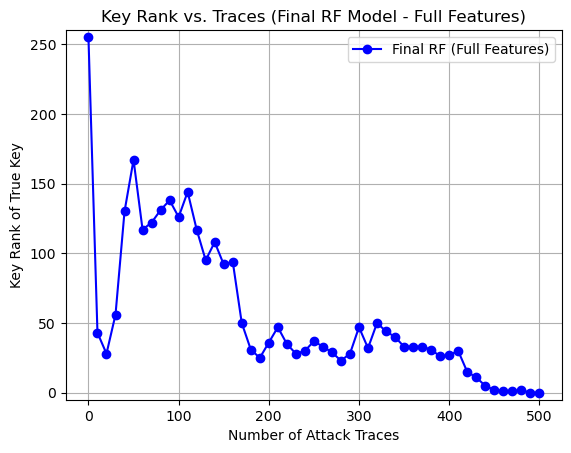

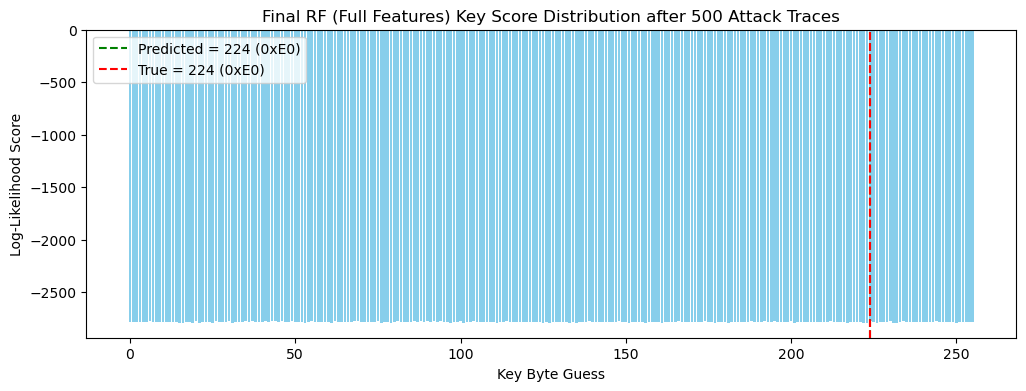


Top 5 Key Candidates for Final RF (Full Features) (Rank, Key Byte, Hex, Score):
Rank  Key Byte   Hex   Log-Likelihood 
---------------------------------------------
0     224        0xE0  -2769.9606      <<< TRUE KEY
1     188        0xBC  -2770.9375     
2     90         0x5A  -2773.1975     
3     104        0x68  -2773.6247     
4     81         0x51  -2773.9756     
---------------------------------------------


In [11]:
# Evaluate the final RF model
rf_final_ranks, rf_final_trace_counts, rf_final_scores, rf_final_pred_key, rf_final_num_traces_scores = evaluate_model_performance(
    model=rf_final_model,
    model_name="Final RF (Full Features)",
    X_attack_eval=X_attack_scaled,
    plaintexts_eval=attack_plaintexts,
    true_key_eval=true_key_byte,
    sbox_eval=SBOX,
    target_plaintext_idx_eval=TARGET_KEY_BYTE_INDEX,
    max_traces_plot=PLOT_MAX_ATTACK_TRACES,
    plot_step_eval=10  # Renamed to avoid conflict if used as global
)

# Plot results for Final RF Model
plot_key_rank_vs_traces(rf_final_trace_counts, rf_final_ranks, "Final RF (Full Features)", color='blue')
plt.xlabel("Number of Attack Traces")
plt.ylabel("Key Rank of True Key")
plt.title("Key Rank vs. Traces (Final RF Model - Full Features)")
plt.grid(True)
plt.ylim(-5, 260)
plt.legend()
plt.show()

plot_key_score_distribution(rf_final_scores, rf_final_pred_key, true_key_byte, 
                             "Final RF (Full Features)", rf_final_num_traces_scores, color='skyblue')
print_top_key_candidates(rf_final_scores, true_key_byte, "Final RF (Full Features)")



--- Feature Importance Analysis (Final RF Model) ---
Top 15 most important time points (features) from Final RF Model:
1. Time Point Index: 156 (Importance: 0.0041)
2. Time Point Index: 619 (Importance: 0.0038)
3. Time Point Index: 149 (Importance: 0.0037)
4. Time Point Index: 514 (Importance: 0.0035)
5. Time Point Index: 147 (Importance: 0.0035)
6. Time Point Index: 150 (Importance: 0.0034)
7. Time Point Index: 515 (Importance: 0.0034)
8. Time Point Index: 182 (Importance: 0.0033)
9. Time Point Index: 202 (Importance: 0.0033)
10. Time Point Index: 618 (Importance: 0.0033)
11. Time Point Index: 254 (Importance: 0.0033)
12. Time Point Index: 151 (Importance: 0.0032)
13. Time Point Index: 95 (Importance: 0.0032)
14. Time Point Index: 96 (Importance: 0.0031)
15. Time Point Index: 516 (Importance: 0.0031)


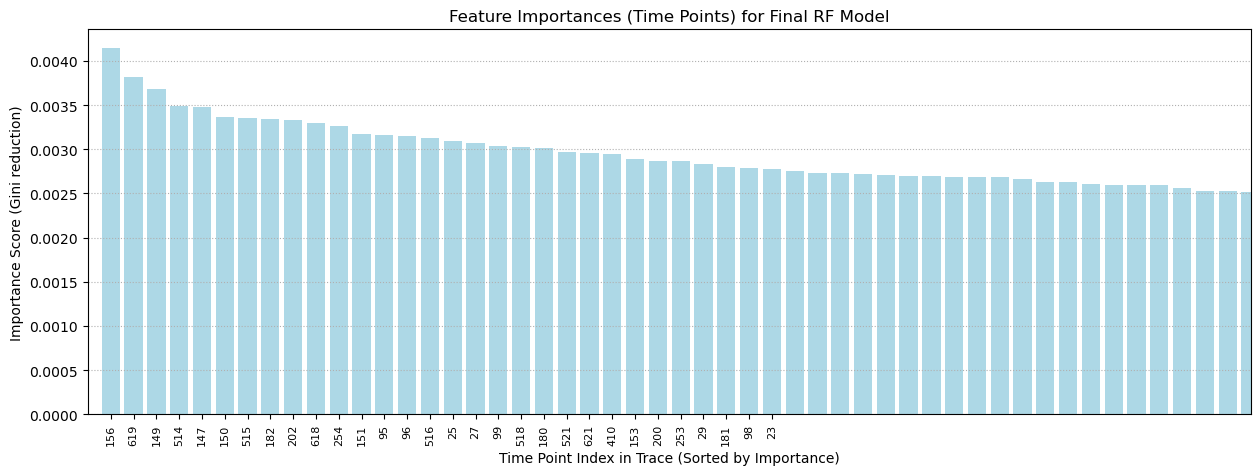

In [23]:
print("\n--- Feature Importance Analysis (Final RF Model) ---")
importances = rf_final_model.feature_importances_
indices = np.argsort(importances)[::-1] # Sort features by importance
num_features_total = X_profiling_scaled.shape[1]

print(f"Top 15 most important time points (features) from Final RF Model:")
for i in range(min(15, num_features_total)):
    print(f"{i + 1}. Time Point Index: {indices[i]} (Importance: {importances[indices[i]]:.4f})")

plt.figure(figsize=(15, 5))
plt.title("Feature Importances (Time Points) for Final RF Model")
# Plot importances sorted, and use sorted indices for x-axis labels for top features
plt.bar(range(num_features_total), importances[indices], color="lightblue", align="center") 
num_ticks_to_show = min(30, num_features_total) # Show labels for up to 30 most important features
plt.xticks(range(num_ticks_to_show), indices[:num_ticks_to_show], rotation=90, fontsize=8)
plt.xlabel("Time Point Index in Trace (Sorted by Importance)")
plt.ylabel("Importance Score (Gini reduction)")
plt.xlim([-1, min(50, num_features_total)]) # Zoom into top 50 important features for better visibility
plt.grid(axis='y', linestyle=':')
plt.show()

In [57]:
print(f"\n--- Selecting Top {N_TOP_FEATURES} Features based on Final RF Model ---")
top_k_indices = indices[:N_TOP_FEATURES]
# print(f"Indices of selected features (first 10): {top_k_indices[:10]}...") # This was in original, can be verbose

X_profiling_reduced = X_profiling_scaled[:, top_k_indices]
X_attack_reduced = X_attack_scaled[:, top_k_indices] # Apply same feature selection to attack set

print(f"Reduced Profiling Training Set shape: {X_profiling_reduced.shape}")
print(f"Reduced Attack Set shape: {X_attack_reduced.shape}")



--- Selecting Top 100 Features based on Final RF Model ---
Reduced Profiling Training Set shape: (50000, 100)
Reduced Attack Set shape: (10000, 100)


In [58]:
print(f"\n--- Training Random Forest Model on Top {N_TOP_FEATURES} Features ---")
rf_reduced_model = RandomForestClassifier(
    n_estimators=N_ESTIMATORS_RF,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    max_depth=MAX_DEPTH_RF,
    min_samples_leaf=MIN_SAMPLES_LEAF_RF,
    verbose=0 # Set to 1 for progress if desired
)
rf_reduced_model.fit(X_profiling_reduced, y_profiling)
print("RF model training on reduced features finished.")



--- Training Random Forest Model on Top 100 Features ---


RF model training on reduced features finished.



--- Evaluating RF Reduced (100 features) Model on Attack Set ---
Calculating Key Rank vs. Traces for RF Reduced (100 features) model (up to 500 traces)...
Precomputing probabilities for 10000 attack traces using RF Reduced (100 features)...
Probability precomputation finished. Duration: 0.94 seconds
Finished calculating ranks for plot.

--- RF Reduced (100 features) Model Key Score Analysis (using 500 traces) ---
RF Reduced (100 features) Model's predicted key byte = 224 (0xE0)
True key byte (for evaluation only) = 224 (0xE0)
Attack successful!


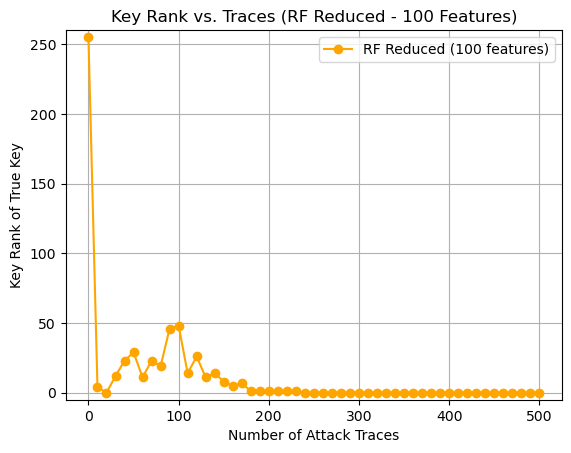

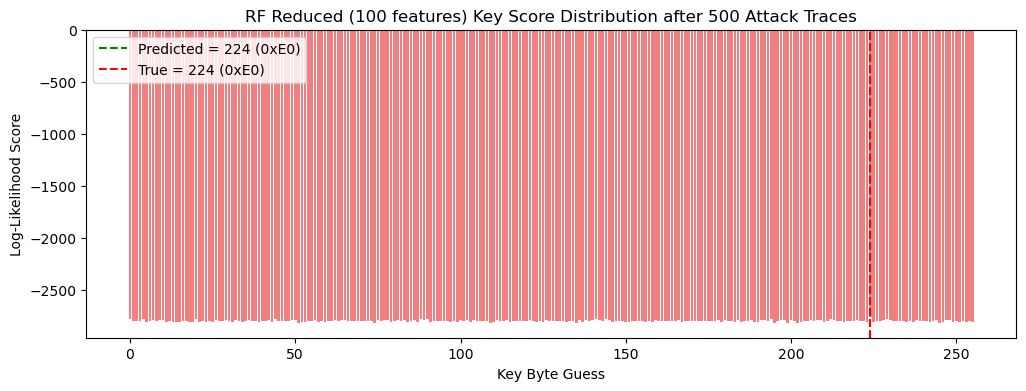


Top 5 Key Candidates for RF Reduced (100 features) (Rank, Key Byte, Hex, Score):
Rank  Key Byte   Hex   Log-Likelihood 
---------------------------------------------
0     224        0xE0  -2761.7855      <<< TRUE KEY
1     144        0x90  -2776.1576     
2     90         0x5A  -2776.7480     
3     141        0x8D  -2778.0547     
4     4          0x04  -2778.4346     
---------------------------------------------


In [59]:
rf_reduced_ranks, rf_reduced_trace_counts, rf_reduced_scores, rf_reduced_pred_key, rf_reduced_num_traces_scores = evaluate_model_performance(
    model=rf_reduced_model,
    model_name=f"RF Reduced ({N_TOP_FEATURES} features)",
    X_attack_eval=X_attack_reduced, # Use reduced attack set
    plaintexts_eval=attack_plaintexts,
    true_key_eval=true_key_byte,
    sbox_eval=SBOX,
    target_plaintext_idx_eval=TARGET_KEY_BYTE_INDEX,
    max_traces_plot=PLOT_MAX_ATTACK_TRACES,
    plot_step_eval=10
)

# Plot results for Reduced RF Model
plot_key_rank_vs_traces(rf_reduced_trace_counts, rf_reduced_ranks, f"RF Reduced ({N_TOP_FEATURES} features)", color='orange')
plt.xlabel("Number of Attack Traces")
plt.ylabel("Key Rank of True Key")
plt.title(f"Key Rank vs. Traces (RF Reduced - {N_TOP_FEATURES} Features)")
plt.grid(True)
plt.ylim(-5, 260)
plt.legend()
plt.show()

plot_key_score_distribution(rf_reduced_scores, rf_reduced_pred_key, true_key_byte,
                             f"RF Reduced ({N_TOP_FEATURES} features)", rf_reduced_num_traces_scores, color='lightcoral')
print_top_key_candidates(rf_reduced_scores, true_key_byte, f"RF Reduced ({N_TOP_FEATURES} features)")


In [60]:
#Support Vector Classifier (SVC): Training and Evaluation on Reduced Features

# %%
print(f"\n--- Training and Evaluating SVC on Reduced Features ({N_TOP_FEATURES} features) ---")
print("\nDefining SVC model...")
svc_model = SVC(
    probability=True,    # Essential for predict_proba and our key rank computation
    kernel='rbf',        # Common general-purpose kernel
    C=1.0,               # Regularization parameter
    gamma='scale',       # Kernel coefficient
    cache_size=1000,     # Can increase if memory allows, might speed up training
    verbose=False,       # Set to True for more SVC output during training
    random_state=RANDOM_STATE
)

print("\n--- Training SVC Model ---")
print("WARNING: SVC training with probability=True can be very time-consuming, especially for large datasets!")
start_time_svc_train = time.time()
svc_model.fit(X_profiling_reduced, y_profiling) # Train on REDUCED profiling data
end_time_svc_train = time.time()
print(f"SVC training finished. Duration: {end_time_svc_train - start_time_svc_train:.2f} seconds")



--- Training and Evaluating SVC on Reduced Features (100 features) ---

Defining SVC model...

--- Training SVC Model ---
SVC training finished. Duration: 3383.57 seconds



--- Evaluating SVC Reduced (100 features) Model on Attack Set ---
Calculating Key Rank vs. Traces for SVC Reduced (100 features) model (up to 500 traces)...
Precomputing probabilities for 10000 attack traces using SVC Reduced (100 features)...
Probability precomputation finished. Duration: 498.72 seconds
Finished calculating ranks for plot.

--- SVC Reduced (100 features) Model Key Score Analysis (using 500 traces) ---
SVC Reduced (100 features) Model's predicted key byte = 224 (0xE0)
True key byte (for evaluation only) = 224 (0xE0)
Attack successful!


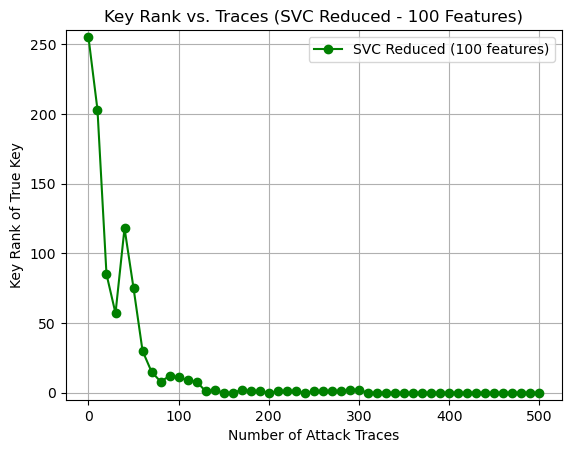

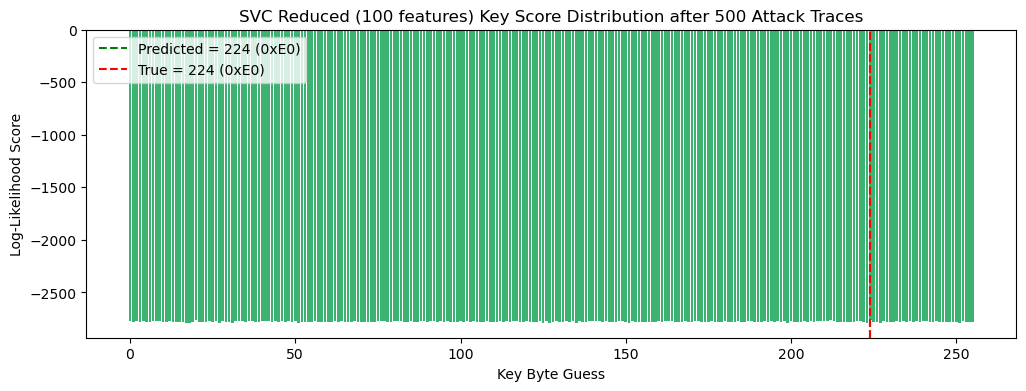


Top 5 Key Candidates for SVC Reduced (100 features) (Rank, Key Byte, Hex, Score):
Rank  Key Byte   Hex   Log-Likelihood 
---------------------------------------------
0     224        0xE0  -2764.6712      <<< TRUE KEY
1     212        0xD4  -2765.9774     
2     20         0x14  -2765.9882     
3     188        0xBC  -2767.2174     
4     100        0x64  -2767.6587     
---------------------------------------------


In [61]:
svc_reduced_ranks, svc_reduced_trace_counts, svc_reduced_scores, svc_reduced_pred_key, svc_reduced_num_traces_scores = evaluate_model_performance(
    model=svc_model,
    model_name=f"SVC Reduced ({N_TOP_FEATURES} features)",
    X_attack_eval=X_attack_reduced, # Use reduced attack set
    plaintexts_eval=attack_plaintexts,
    true_key_eval=true_key_byte,
    sbox_eval=SBOX,
    target_plaintext_idx_eval=TARGET_KEY_BYTE_INDEX,
    max_traces_plot=PLOT_MAX_ATTACK_TRACES,
    plot_step_eval=10
)
# Plot results for SVC Model
plot_key_rank_vs_traces(svc_reduced_trace_counts, svc_reduced_ranks, f"SVC Reduced ({N_TOP_FEATURES} features)", color='green')
plt.xlabel("Number of Attack Traces")
plt.ylabel("Key Rank of True Key")
plt.title(f"Key Rank vs. Traces (SVC Reduced - {N_TOP_FEATURES} Features)")
plt.grid(True)
plt.ylim(-5, 260)
plt.legend()
plt.show()

plot_key_score_distribution(svc_reduced_scores, svc_reduced_pred_key, true_key_byte,
                             f"SVC Reduced ({N_TOP_FEATURES} features)", svc_reduced_num_traces_scores, color='mediumseagreen')
print_top_key_candidates(svc_reduced_scores, true_key_byte, f"SVC Reduced ({N_TOP_FEATURES} features)")
